## Pre-processing Data

In [1]:
import json

# get all of the 100 random recipes received from the api (they were saved to a file)
recipesNutrients = json.load(open("recipesNutrients2.txt"))

In [2]:
import unirest

# gets one recipe to use to predict after training
def nutritions():
    response = unirest.get("https://spoonacular-recipe-food-nutrition-v1.p.mashape.com/recipes/541391/information?includeNutrition=true",
      headers={
        "X-Mashape-Key": "uI9T1GTt8nmshcUUWJOjq8TQNGBgp1P9Zffjsn7dAbkmTSDt1k",
        "Accept": "application/json"
      }
    )
    recipeInfo = response.body
    # get all of the nutrition information
    recipeNutritions = recipeInfo['nutrition']['nutrients']
    # create dict where each key is a nutrition and its value is the value of the nutrition
    nutritionsDict = {nutrition['title']: nutrition['amount'] for nutrition in recipeNutritions}# if nutrition['title'] in selectedNutritions}
    return nutritionsDict


nutritions = nutritions()
nutritions

{u'Caffeine': 9.48,
 u'Calcium': 79.11,
 u'Calories': 354.6,
 u'Carbohydrates': 7.9,
 u'Cholesterol': 115.19,
 u'Copper': 0.33,
 u'Fat': 35.72,
 u'Fiber': 2.44,
 u'Folate': 14.85,
 u'Iron': 1.91,
 u'Magnesium': 39.71,
 u'Manganese': 0.43,
 u'Phosphorus': 120.52,
 u'Potassium': 175.12,
 u'Protein': 6.8,
 u'Saturated Fat': 18.61,
 u'Selenium': 4.84,
 u'Sodium': 247.17,
 u'Sugar': 1.9,
 u'Vitamin A': 1028.38,
 u'Vitamin B1': 0.03,
 u'Vitamin B12': 0.22,
 u'Vitamin B2': 0.12,
 u'Vitamin B3': 0.24,
 u'Vitamin B5': 0.45,
 u'Vitamin B6': 0.05,
 u'Vitamin D': 0.66,
 u'Vitamin E': 0.6,
 u'Vitamin K': 3.01,
 u'Zinc': 1.15}

In [3]:
# get all of the unique nutrients that are present in random recipes since not each recipe has all of the nutrients
all_keys = list(set().union(*(d.keys() for d in recipesNutrients)))
# save it to a file because we will need it in the future
f = open('nutritions.txt', 'w')
json.dump(all_keys, f)
f.close()

In [5]:
import numpy as np
# create the nutrition vector with all of the nutrition keys so each element corresponds to the correct nutrition
# this is for the one prediction example
nutrition_vector = [nutritions[nutrition] if nutrition in nutritions else 0 for nutrition in all_keys]
nutrition_vector = np.matrix(nutrition_vector)

In [6]:
# create the nutrition vectors for all the 100 random recipes 
all_nutritions = []
for nutritions in recipesNutrients: 
    vector = [nutritions[nut] if nut in nutritions else 0 for nut in all_keys]
    all_nutritions.append(vector)
nutrition_vectors = np.matrix(all_nutritions)

## Fuzzy C-Means Clustering

[0]


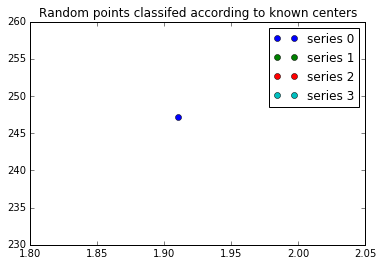

In [7]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
%matplotlib inline


colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# train the 100 examples
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(nutrition_vectors.T, 3, 1.5, error=0.005, maxiter=1000, init=None)

# predict one example
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(nutrition_vector.T, cntr, 1.5, error=0.005, maxiter=1000)

# get to which cluster the example belongs to
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization
print(cluster_membership)

# plot the example 
fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(4):
    ax3.plot(nutrition_vector[cluster_membership == j, 0],
             nutrition_vector[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

## Experiments

In [8]:
import pandas as pd

# experiment with which m values and amount of clusters training goes the best by looking at the fpc
experiments = []
m_list = [1.2, 1.5, 2, 2.5, 3]
# check for different amount of clusters
for nclusters in range(2, 5):
    # check for different amount of m's 
    for m in m_list: 
        _, _, _, _, _, _, fpc = fuzz.cluster.cmeans(nutrition_vectors.T, nclusters, m, error=0.005, maxiter=1000, init=None)
        experiments.append((nclusters, m, fpc))
df = pd.DataFrame(experiments, columns=["cluster", "m-value", "fpc"])
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster,2.00000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000
m-value,1.20000,1.500000,2.000000,2.500000,3.000000,1.200000,1.500000,2.000000,2.500000,3.000000,1.200000,1.500000,2.000000,2.500000,3.000000
fpc,0.99811,0.985649,0.942825,0.875259,0.804129,0.964844,0.910918,0.798526,0.671445,0.571815,0.977677,0.920497,0.782949,0.514082,0.468947


In [11]:
# this is to make sense of what the u.argmax does (not used for fuzzy cmeans clustering)
print(u.argmax(axis=0) == j)
print(nutrition_vectors.T[0])
print(nutrition_vectors.T[0, u.argmax(axis=0) == j], j)
u.argmax(axis = 0)

[False]
[[  1.     0.65   4.84   2.27   1.32   1.48   2.13   0.62   3.1    1.14
    1.06   0.93   2.     0.93   1.44   4.92   1.61   0.     1.95   3.18
    2.16   3.09   1.94   1.35   0.66   1.33   5.34   3.1    1.53   0.83
    3.88   3.18   0.67   3.57   1.17   0.53   2.92   0.9    3.53   1.26
    1.42   1.85   0.43   3.27   2.75   4.38   7.81   1.03   0.75   1.09
    1.4    2.88   3.78   0.86   7.96   3.82   1.2    2.81   1.34   3.77
    5.3    6.35   3.59   1.72   0.74   0.47   2.94  12.12   2.15   4.2
    1.45   4.17   1.68   3.99   1.28   5.92   2.32   0.25   1.4    2.28
    1.2    2.04   8.62   2.04   3.12   1.89   0.85   2.64]]
[] 3


C:\Users\Urja\Anaconda3\envs\py27\lib\site-packages\numpy\matrixlib\defmatrix.py:318: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 88 but corresponding boolean dimension is 1
  out = N.ndarray.__getitem__(self, index)


array([0], dtype=int64)